In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
import networkx as nx

In [23]:
#### Note
#### In order to compute beta values, beta = 1/theta

#### Configuration and Setup

In [14]:
# Define the root directory and dataset name
DATA_ROOT = r'E:\RABBIT_DATA\NEW_AI_RESULTS_V11\\'
DATA_NAME = 'Rabbit'

# Voxel dimensions in nanometers
VOXEL_SIZE_X = 55.5
VOXEL_SIZE_Y = 55.5
VOXEL_SIZE_Z = 150

# Conversion factor from nanometers to micrometers
UNIT_CONVERSION = 1e3

# Percentile value for thresholding (adjustable)
PERCENTILE_VALUE = 90  # For example, 95th percentile

# Flag to determine data processing mode
AGGREGATE_DATA = False  # Set to False to process each cell individually

# Flag to control plotting of only one example cell in per-cell analysis
SHOW_ONLY_ONE_CELL_PLOT = True  # Set to False to plot all cells

APPLY_TUKEY_FILTER = True  # Set to True to apply Tukey's Fences filtration

#### Define Gamma Mixture Model and Fitting

In [15]:
def fit_gamma_mixture_model(x_values, data_name='Data', nbins=50, verbose=True, plot=True, percentile_value=95):
    """
    Fit a two-component gamma mixture model to the data using the method of moments for initial parameter estimation.
    """
    # Method of Moments for Initial Parameter Estimation
    def estimate_initial_params(data):
        # Sort data
        data_sorted = np.sort(data)
        n = len(data_sorted)

        # Split data into two subsets
        split_index = n // 2  # Use median to split the data
        data1 = data_sorted[:split_index]
        data2 = data_sorted[split_index:]

        # Calculate sample means and variances
        mean1 = np.mean(data1)
        var1 = np.var(data1, ddof=1)  # Unbiased estimator
        mean2 = np.mean(data2)
        var2 = np.var(data2, ddof=1)

        # Estimate alpha and theta for each component
        theta1 = var1 / mean1
        alpha1 = mean1 / theta1
        theta2 = var2 / mean2
        alpha2 = mean2 / theta2

        # Estimate mixing proportion
        pi = len(data1) / n

        return alpha1, theta1, alpha2, theta2, pi

    # Define the gamma mixture PDF
    def gamma_mixture_pdf(params, x):
        alpha1, theta1, alpha2, theta2, pi = params
        gamma1_pdf = gamma.pdf(x, a=alpha1, scale=theta1)
        gamma2_pdf = gamma.pdf(x, a=alpha2, scale=theta2)
        return pi * gamma1_pdf + (1 - pi) * gamma2_pdf

    # Negative log-likelihood function
    def negative_log_likelihood(params, data):
        alpha1, theta1, alpha2, theta2, pi = params
        if any(p <= 0 for p in params[:-1]) or not (0 < pi < 1):
            return np.inf
        pdf = gamma_mixture_pdf(params, data)
        # Avoid division by zero or log of zero
        pdf = np.clip(pdf, 1e-10, None)
        return -np.sum(np.log(pdf))

    # Convert data to numpy array
    x_array = np.array(x_values)

    # Estimate initial parameters using method of moments
    alpha1_init, theta1_init, alpha2_init, theta2_init, pi_init = estimate_initial_params(x_array)
    initial_guess = [alpha1_init, theta1_init, alpha2_init, theta2_init, pi_init]

    if verbose:
        print(f"Initial parameter estimates:")
        print(f"Alpha1: {alpha1_init:.4f}, theta1: {theta1_init:.4f}, "
              f"Alpha2: {alpha2_init:.4f}, theta2: {theta2_init:.4f}, Pi: {pi_init:.4f}")

    # Set parameter bounds
    bounds = [(1e-6, None), (1e-6, None), (1e-6, None), (1e-6, None), (1e-3, 1 - 1e-3)]

    # Optimize parameters
    result = minimize(negative_log_likelihood, initial_guess, args=(x_array,), bounds=bounds)
    fit_params = result.x

    if verbose:
        print("Fitted parameters:")
        print("Alpha1: {:.4f}, theta1: {:.4f}, Alpha2: {:.4f}, theta2: {:.4f}, Pi: {:.4f}".format(*fit_params))

    # Calculate R^2
    hist, bin_edges = np.histogram(x_array, bins=nbins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    predicted_densities = gamma_mixture_pdf(fit_params, bin_centers)
    ss_tot = np.sum((hist - np.mean(hist)) ** 2)
    ss_res = np.sum((hist - predicted_densities) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    if verbose:
        print(f"R^2: {r_squared:.4f}")

    # Extract parameters
    alpha1, theta1, alpha2, theta2, pi = fit_params

    # Calculate excess kurtosis of both gamma components
    first_gamma_excess_kurtosis = 6 / alpha1
    second_gamma_excess_kurtosis = 6 / alpha2
    if verbose:
        print(f"Excess kurtosis of the first gamma component: {first_gamma_excess_kurtosis:.4f}")
        print(f"Excess kurtosis of the second gamma component: {second_gamma_excess_kurtosis:.4f}")

    # Calculate the specified percentile of the second gamma distribution
    threshold_percentile = gamma.ppf(percentile_value / 100, a=alpha2, scale=theta2)
    if verbose:
        print(f"{percentile_value}th percentile of the second gamma distribution: {threshold_percentile:.4f}")

    # Calculate the mean and standard deviation of the gamma components
    first_gamma_mean = alpha1 * theta1
    first_gamma_std = np.sqrt(alpha1) * theta1
    second_gamma_mean = alpha2 * theta2
    second_gamma_std = np.sqrt(alpha2) * theta2
    if verbose:
        print(f"First gamma component - Mean: {first_gamma_mean:.4f}, Std Dev: {first_gamma_std:.4f}")
        print(f"Second gamma component - Mean: {second_gamma_mean:.4f}, Std Dev: {second_gamma_std:.4f}")

    # Plotting results only if plot=True
    fig = None
    if plot:
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
        ax.hist(x_array, bins=nbins, density=True, alpha=0.5, label=f'{data_name} Data')
        x_range = np.linspace(min(x_array), max(x_array), 1000)

        # Plot the individual gamma distributions
        gamma1_pdf = gamma.pdf(x_range, a=alpha1, scale=theta1)
        gamma2_pdf = gamma.pdf(x_range, a=alpha2, scale=theta2)
        ax.plot(x_range, pi * gamma1_pdf, 'g--', label='First Gamma Component')
        ax.plot(x_range, (1 - pi) * gamma2_pdf, 'b--', label='Second Gamma Component')

        # Plot the fitted mixture
        ax.plot(x_range, gamma_mixture_pdf(fit_params, x_range), 'r-', label='Fitted Gamma Mixture')

        # Plot the percentile line
        ax.axvline(x=threshold_percentile, color='black', linestyle='dashdot',
                    label=f'{percentile_value}th Percentile of Second Gamma')

        ax.set_xlabel('Volume (μm³)')
        ax.set_ylabel('Density')
        ax.set_title(f'PDF of {data_name} RyR Cluster Sizes and Fitted Gamma Mixture')

        # Adjust the layout to make room for the legend
        plt.subplots_adjust(bottom=0.3)

        # Place the legend below the plot
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                  fancybox=True, shadow=True, ncol=2)

        # Return the figure
        fig = plt.gcf()
    return fit_params, r_squared, threshold_percentile, fig

#### Data Collection

In [16]:
def get_matching_files(root_dir, pattern):
    """
    Recursively find files matching the given pattern in the directory and sub-directories.
    """
    matching_files = []
    for current_root, dirs, files in os.walk(root_dir):
        for file_name in files:
            if pattern in file_name:
                matching_files.append(os.path.join(current_root, file_name))
    return matching_files

def extract_file_type(file_name):
    """
    Extract the specific file type from the filename, handling complex names.
    """
    parts = file_name.split('_')
    try:
        if "cluster" in file_name:
            type_part = '_'.join(parts[parts.index('labels') + 1:]).rsplit('.', 1)[0]
        else:
            type_part = parts[-1].split('.')[0]
    except ValueError:
        type_part = file_name.rsplit('.', 1)[0]
    return type_part

def collect_files(root_dir, filter_dir):
    """
    Collect specific files and organize them into a DataFrame, filtered by matching .jpg files in a directory.
    """
    # Collect all .jpg files in the filter directory
    filter_files = {os.path.basename(f): f for f in get_matching_files(filter_dir, '.jpg')}
    print(f"Found {len(filter_files)} .jpg files for filtering in {filter_dir}")
    
    data_records = []
    # Walk through each subdirectory and check for matching .jpg file presence
    for subdir, dirs, files in os.walk(root_dir):
        # Skip the filter_dir (CELLS_TO_USE directory) while processing subdirectories
        if os.path.abspath(subdir) == os.path.abspath(filter_dir):
            continue
        
        subdir_jpg_files = [f for f in files if f.endswith('.jpg')]
        if any(jpg in filter_files for jpg in subdir_jpg_files):
            file_dict = {}
            for file_name in files:
                file_type = extract_file_type(file_name)
                if file_type in ['adj_matrix', 'alphashape', 'centroids', 'clusterlabels', 
                                 'filteredvolume', 'neighboralphacentroid', 'surfacearea', 
                                 'volume', 'volumes', 'voxellist', 'adjmatrix']:
                    file_dict[file_type] = os.path.join(subdir, file_name)
            if file_dict:
                data_records.append(file_dict)
    
    # Create DataFrame
    data_df = pd.DataFrame(data_records)
    if data_df.empty:
        print("No data collected. DataFrame is empty.")
    else:
        print("DataFrame created successfully with collected files.")
    return data_df

filter_directory = os.path.join(DATA_ROOT, 'CELLS_TO_USE')

# Collect files and create input DataFrame
input_dataframe = collect_files(DATA_ROOT, filter_directory)

# Extract the list of volume files to process
volume_files = input_dataframe['volumes'].tolist()
print(f"Found {len(volume_files)} volume files to process.")

Found 31 .jpg files for filtering in E:\RABBIT_DATA\NEW_AI_RESULTS_V11\\CELLS_TO_USE
DataFrame created successfully with collected files.
Found 31 volume files to process.


#### Data Processing

In [17]:
# Parameters
APPLY_TUKEY_FILTER = True  # Set to True to apply Tukey's Fences filtration

# Helper function for Tukey's Fences filtration
def tukeys_fences(data, k=3.0):
    """
    Apply Tukey's Fences to filter out outliers from the data.
    Returns the filtered data.
    """
    data = np.array(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_fence = q1 - k * iqr
    upper_fence = q3 + k * iqr
    filtered_data = data[(data >= lower_fence) & (data <= upper_fence)]
    return filtered_data

# Initialize data containers
if AGGREGATE_DATA:
    cumulative_cluster_volumes = []
else:
    per_cell_data = {}  # Dictionary to store data per cell

# Loop over the rows in input_dataframe
for idx, row in input_dataframe.iterrows():
    volume_file_path = row['volumes']
    adj_matrix_file_path = row['adjmatrix']
    surface_area_file_path = row.get('surfacearea')
    cell_volume_file_path = row.get('volume')
    # Extract cell identifier (using the file name)
    cell_identifier = os.path.basename(volume_file_path)
    print(f"Processing cell '{cell_identifier}' ({idx + 1}/{len(input_dataframe)})")
    
    # Read the volume data
    df_volume = pd.read_csv(volume_file_path, header=None, names=['x', 'y', 'z', 'volume'])
    
    # Convert voxel counts to volume in μm³
    df_volume['volume_um3'] = (df_volume['volume'] * VOXEL_SIZE_X * VOXEL_SIZE_Y * VOXEL_SIZE_Z) / (UNIT_CONVERSION ** 3)
    
    # Apply Tukey's Fences filtration if enabled
    if APPLY_TUKEY_FILTER:
        volumes_um3 = tukeys_fences(df_volume['volume_um3'])
    else:
        volumes_um3 = df_volume['volume_um3']
    
    # Calculate RyR cluster statistics
    ryr_cluster_mean = volumes_um3.mean()
    ryr_cluster_std = volumes_um3.std()
    num_ryr_clusters = len(volumes_um3)
    
    # Read the surface area and cell volume files and convert units
    if surface_area_file_path and os.path.exists(surface_area_file_path):
        # Assume the surface area file contains a single numeric value
        cell_surface_area_nm2 = np.genfromtxt(surface_area_file_path)
        cell_surface_area_um2 = cell_surface_area_nm2 / (UNIT_CONVERSION ** 2)
    else:
        cell_surface_area_um2 = np.nan  # Handle missing data

    if cell_volume_file_path and os.path.exists(cell_volume_file_path):
        # Assume the volume file contains a single numeric value
        cell_volume_nm3 = np.genfromtxt(cell_volume_file_path)
        cell_volume_um3 = cell_volume_nm3 / (UNIT_CONVERSION ** 3)
    else:
        cell_volume_um3 = np.nan  # Handle missing data
    
    if AGGREGATE_DATA:
        cumulative_cluster_volumes.extend(volumes_um3)
    else:
        # Store the data per cell
        per_cell_data[cell_identifier] = {
            'volumes': volumes_um3,
            'volume_file_path': volume_file_path,
            'adj_matrix_file_path': adj_matrix_file_path,
            'df_volume': df_volume,  # Store the DataFrame for later use
            'ryr_cluster_mean': ryr_cluster_mean,
            'ryr_cluster_std': ryr_cluster_std,
            'num_ryr_clusters': num_ryr_clusters,
            'cell_surface_area_um2': cell_surface_area_um2,
            'cell_volume_um3': cell_volume_um3
        }

Processing cell 'RAW_55.5x55.5x150nm_image000002_3DCLAHE_volumes.csv' (1/31)
Processing cell 'RAW_55.5x55.5x150nm_image000005-1_3DCLAHE_volumes.csv' (2/31)
Processing cell 'RAW_55.5x55.5x150nm_image000006_3DCLAHE_volumes.csv' (3/31)
Processing cell 'RAW_55.5x55.5x150nm_image000007_3DCLAHE_volumes.csv' (4/31)
Processing cell 'RAW_55.5x55.5x150nm_image000008_3DCLAHE_volumes.csv' (5/31)
Processing cell 'RAW_55.5x55.5x150nm_image000010_3DCLAHE_volumes.csv' (6/31)
Processing cell 'RAW_55.5x55.5x150nm_image000011_3DCLAHE_volumes.csv' (7/31)
Processing cell 'RAW_55.5x55.5x150nm_image000012_3DCLAHE_volumes.csv' (8/31)
Processing cell 'RAW_55.5x55.5x150nm_image000015_3DCLAHE_volumes.csv' (9/31)
Processing cell 'RAW_55.5x55.5x150nm_image000017_3DCLAHE_volumes.csv' (10/31)
Processing cell 'RAW_55.5x55.5x150nm_image000018_3DCLAHE_volumes.csv' (11/31)
Processing cell 'RAW_55.5x55.5x150nm_image000021_3DCLAHE_volumes.csv' (12/31)
Processing cell 'RAW_55.5x55.5x150nm_image000022_3DCLAHE_volumes.csv' (

#### Data Analysis, Visualization, and Saving Outputs

Example cell for visualization: RAW_55.5x55.5x150nm_image000002_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000002_3DCLAHE_volumes.csv


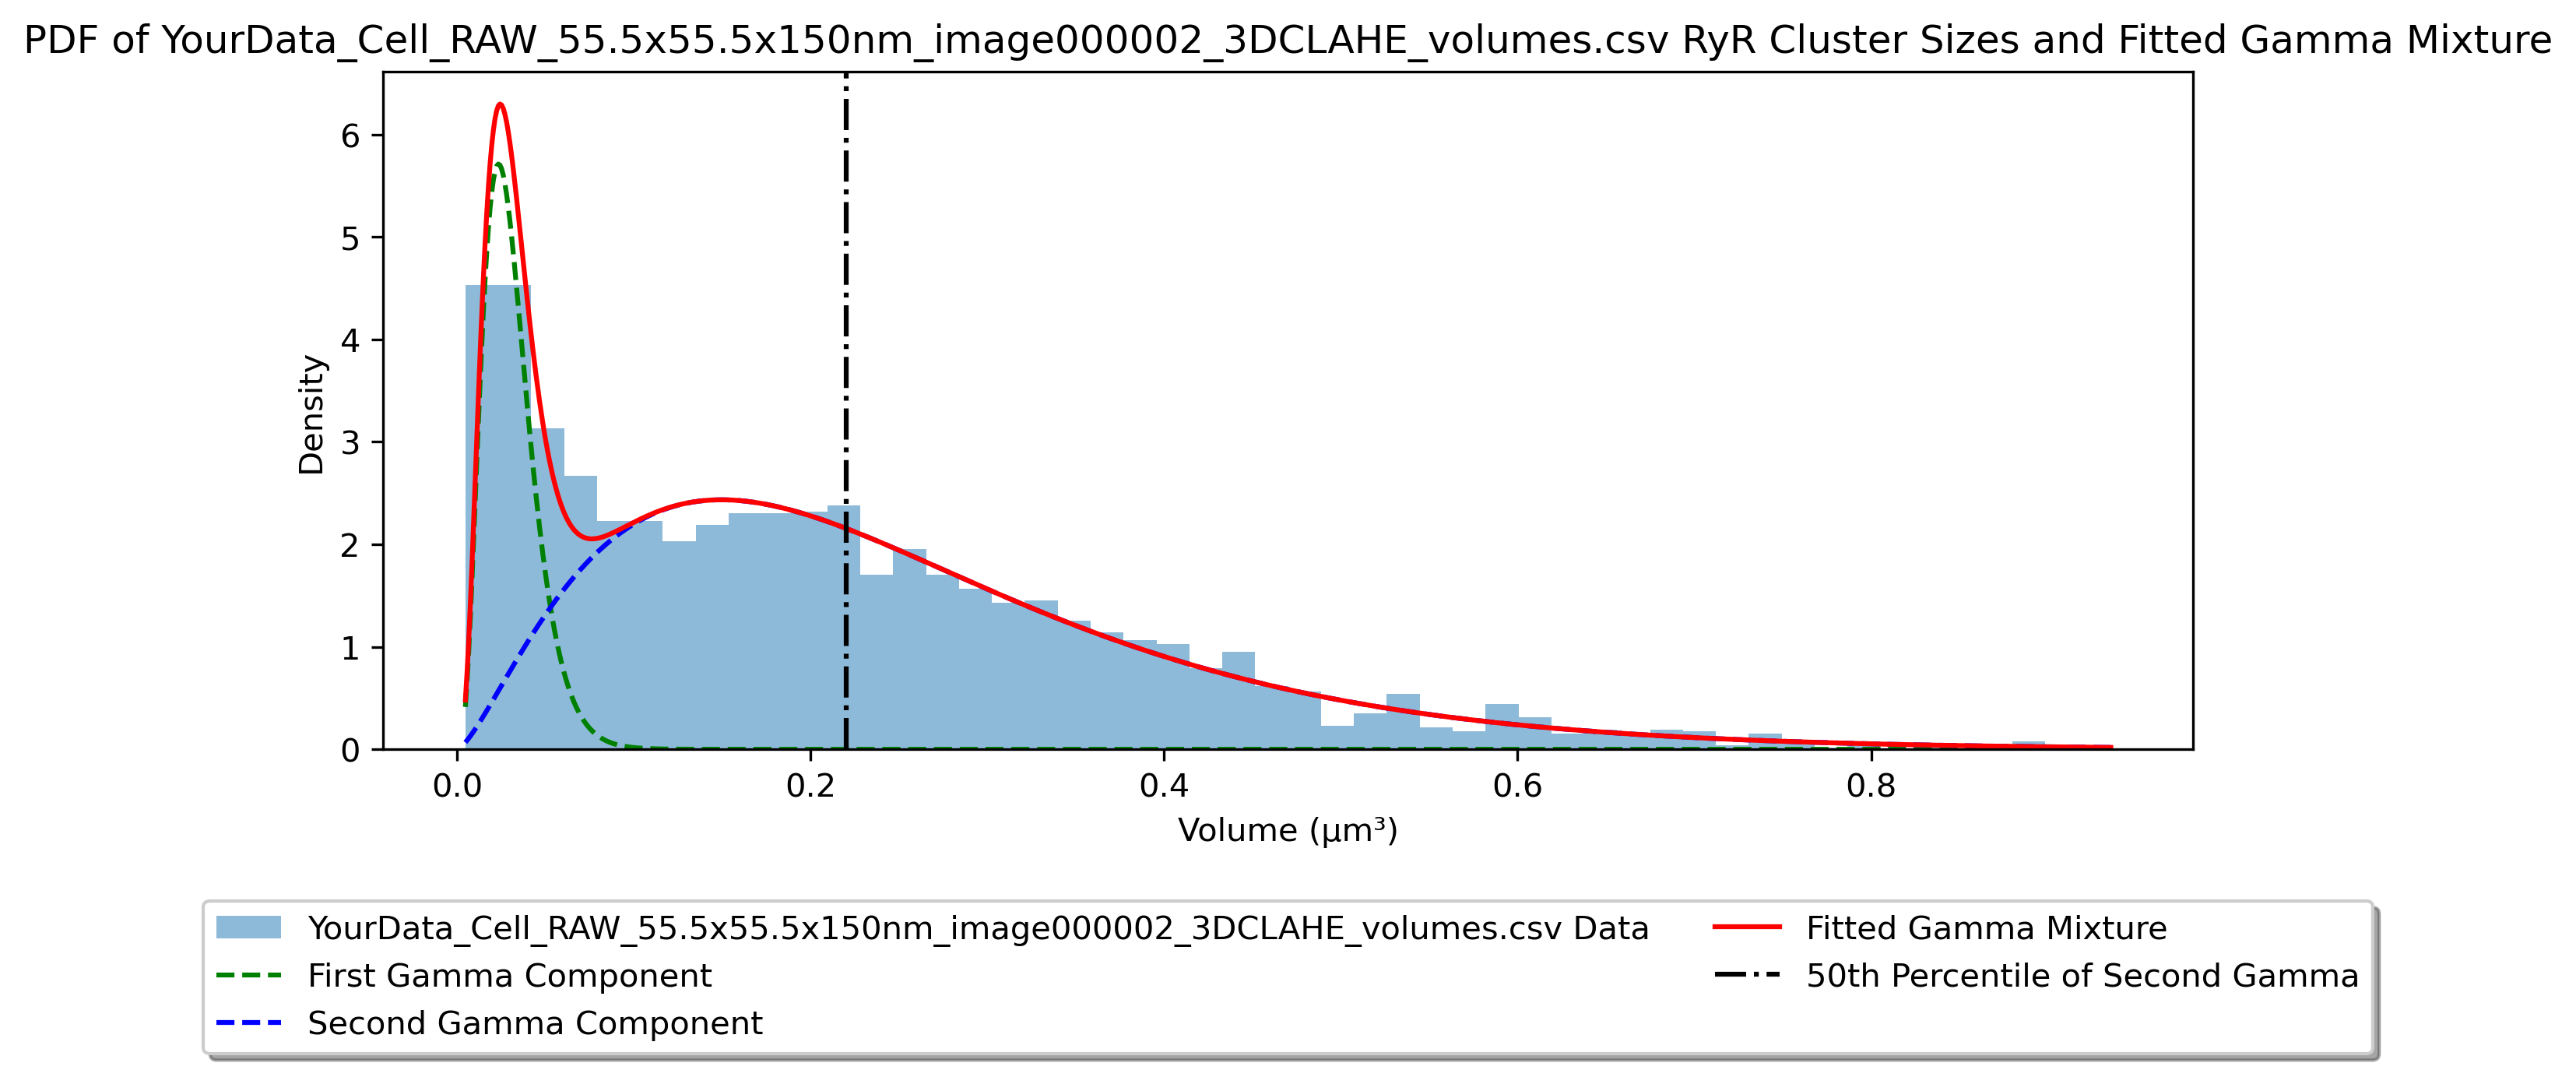

Analyzing data for cell RAW_55.5x55.5x150nm_image000005-1_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000006_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000007_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000008_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000010_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000011_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000012_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000015_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000017_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000018_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000021_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000022_3DCLAHE_volumes.csv
Analyzing data for cell RAW_55.5x55.5x150nm_image000025-1_3DCLAHE_volumes.csv
Analyzin

In [18]:
output_dir = 'results'
os.makedirs(output_dir, exist_ok=True)

import matplotlib.pyplot as plt

# Initialize a list to collect fitted parameters for all cells
all_cells_params = []
# Initialize a list to collect neighbor hierarchy analysis results
neighbor_hierarchy_results = []
# Initialize a list to collect per-cell measurements
per_cell_measurements = []

# Customizable parameters
FIGURE_WIDTH = 12
FIGURE_HEIGHT = 6
TITLE_FONTSIZE = 16
AXIS_LABEL_FONTSIZE = 18
TICK_LABEL_FONTSIZE = 16
LEGEND_FONTSIZE = 12

PERCENTILE_VALUE = 50  # Adjust this value as needed
AGGREGATE_DATA = False  # Set this to True if you want to aggregate data across cells
SHOW_ONLY_ONE_CELL_PLOT = True  # Set this to True if you want to show plot for only one cell
DATA_NAME = 'YourData'  # Replace with your actual data name

if AGGREGATE_DATA:
    # Prepare cumulative data for analysis
    print("Data aggregation completed. Proceeding with cumulative data analysis.")
    data_to_analyze = np.array(cumulative_cluster_volumes)
    print('Total RyR Clusters : ', len(data_to_analyze))

    # Fit the gamma mixture model
    print("Fitting gamma mixture model to cumulative data...")
    fit_params, r_squared, threshold_percentile, _ = fit_gamma_mixture_model(
        data_to_analyze, data_name=DATA_NAME, nbins=100, verbose=True, plot=False
    )

    # Create a new figure with adjusted dimensions
    fig, ax = plt.subplots(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT), dpi=300)

    # Plot the histogram
    ax.hist(data_to_analyze, bins=100, density=True, alpha=0.5, label=f'{DATA_NAME} Data')

    # Plot the fitted mixture and components
    x_range = np.linspace(min(data_to_analyze), max(data_to_analyze), 1000)
    alpha1, theta1, alpha2, theta2, pi = fit_params
    gamma1_pdf = gamma.pdf(x_range, a=alpha1, scale=theta1)
    gamma2_pdf = gamma.pdf(x_range, a=alpha2, scale=theta2)
    ax.plot(x_range, pi * gamma1_pdf, 'g--', label='First Gamma Component')
    ax.plot(x_range, (1 - pi) * gamma2_pdf, 'b--', label='Second Gamma Component')
    ax.plot(x_range, pi * gamma1_pdf + (1 - pi) * gamma2_pdf, 'r-', label='Fitted Gamma Mixture')

    # Plot the percentile line
    ax.axvline(x=threshold_percentile, color='black', linestyle='dashdot',
               label=f'95th Percentile of Second Gamma')

    # Set labels and title with customizable font sizes
    ax.set_xlabel('Volume (μm³)', fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel('Density', fontsize=AXIS_LABEL_FONTSIZE)
    #ax.set_title(f'PDF of {DATA_NAME} RyR Cluster Sizes and Fitted Gamma Mixture', fontsize=TITLE_FONTSIZE)

    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)

    # Adjust the layout to make room for the legend
    plt.subplots_adjust(bottom=0.2)

    # Place the legend below the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=2, fontsize=LEGEND_FONTSIZE)

    # Display the plot for cumulative data before closing
    plt.show()

    # Save and close the figure
    plot_filename = os.path.join(output_dir, f'{DATA_NAME}_gamma_mixture_plot.png')
    fig.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free up memory
    print(f"Plot saved to {plot_filename}")

    # Save the fitted parameters with 2 decimal precision
    params_filename = os.path.join(output_dir, f'{DATA_NAME}_fitted_params.csv')
    params_df = pd.DataFrame([fit_params], columns=['Alpha1', 'theta1', 'Alpha2', 'theta2', 'Pi'])
    params_df = params_df.round(2)  # Round to 2 decimal places
    params_df.to_csv(params_filename, index=False)
    print(f"Fitted parameters saved to {params_filename}")
else:
    # Choose one example cell to display the plot
    example_cell_identifier = list(per_cell_data.keys())[0]
    print(f"Example cell for visualization: {example_cell_identifier}")

    for cell_identifier, cell_data in per_cell_data.items():
        cell_volumes = cell_data['volumes']
        cell_data_name = f'{DATA_NAME}_Cell_{cell_identifier}'

        # Set verbose to True to see messages for all cells
        verbose = False  # Set to True if you want verbose output

        # Determine if we should display the plot for this cell
        if SHOW_ONLY_ONE_CELL_PLOT and cell_identifier != example_cell_identifier:
            display_plot = False
        else:
            display_plot = True

        plot = True  # Always generate plots for saving

        # Print statements indicating analysis for this cell
        print(f"Analyzing data for cell {cell_identifier}")

        if verbose:
            print(f"Fitting gamma mixture model to data for cell {cell_identifier}...")

        # Fit the gamma mixture model for the cell
        fit_params, r_squared, threshold_percentile, fig = fit_gamma_mixture_model(
            cell_volumes,
            data_name=cell_data_name,
            nbins=50,
            verbose=verbose,
            plot=plot,
            percentile_value=PERCENTILE_VALUE
        )

        # Store fit_params and threshold_percentile in cell_data for later use
        cell_data['fit_params'] = fit_params
        cell_data['threshold_percentile'] = threshold_percentile

        if verbose:
            print(f"Threshold percentile for cell {cell_identifier}: {threshold_percentile}")

        # Display the plot only for the example cell before closing
        if display_plot:
            plt.show()

        # Save and close the figure
        # Ensure the cell identifier is safe for file names
        safe_cell_identifier = ''.join(
            c for c in cell_identifier if c.isalnum() or c in (' ', '.', '_', '-')
        ).rstrip()
        plot_filename = os.path.join(
            output_dir, f'{DATA_NAME}_Cell_{safe_cell_identifier}_gamma_mixture_plot.png'
        )
        fig.savefig(plot_filename, dpi=300)
        plt.close(fig)  # Close the figure to free up memory

        if verbose:
            print(f"Plot saved to {plot_filename}")

        # Collect the fitted parameters and round to 4 decimals
        fit_params_rounded = np.round(fit_params, 4)
        r_squared_rounded = np.round(r_squared, 2)

        # Create a dictionary of parameters with cell identifier
        params_dict = {
            'CellIdentifier': cell_identifier,
            'Alpha1': fit_params_rounded[0],
            'theta1': fit_params_rounded[1],
            'Alpha2': fit_params_rounded[2],
            'theta2': fit_params_rounded[3],
            'Pi': fit_params_rounded[4],
            'R_squared': r_squared_rounded
        }
        all_cells_params.append(params_dict)

        # Collect per-cell measurements
        per_cell_measurements.append({
            'CellIdentifier': cell_identifier,
            'CellSurfaceArea_um2': round(cell_data['cell_surface_area_um2'], 2),
            'CellVolume_um3': round(cell_data['cell_volume_um3'], 2),
            'RyRClusterMean_um3': round(cell_data['ryr_cluster_mean'], 2),
            'RyRClusterStd_um3': round(cell_data['ryr_cluster_std'], 2),
            'NumRyRClusters': cell_data['num_ryr_clusters']
        })

# After processing all cells, you can save the results as needed

# Save all_cells_params to a CSV file
params_df = pd.DataFrame(all_cells_params)
params_filename = os.path.join(output_dir, f'{DATA_NAME}_fitted_params_per_cell.csv')
params_df.to_csv(params_filename, index=False)
print(f"Fitted parameters per cell saved to {params_filename}")

# Save per-cell measurements to a CSV file
per_cell_measurements_df = pd.DataFrame(per_cell_measurements)
measurements_filename = os.path.join(output_dir, f'{DATA_NAME}_per_cell_measurements.csv')
per_cell_measurements_df.to_csv(measurements_filename, index=False)
print(f"Per-cell measurements saved to {measurements_filename}")

In [19]:
# After processing all cells, create a master DataFrame and save it
master_params_df = pd.DataFrame(all_cells_params)

# Rearrange columns
master_params_df = master_params_df[
    ['CellIdentifier', 'Alpha1', 'theta1', 'Alpha2', 'theta2', 'Pi', 'R_squared']
]

# Save the master table of fitted parameters
master_params_filename = os.path.join(output_dir, f'{DATA_NAME}_master_fitted_params.csv')
master_params_df.to_csv(master_params_filename, index=False)
print(f"Master fitted parameters saved to {master_params_filename}")

# Create DataFrame for per-cell measurements
per_cell_measurements_df = pd.DataFrame(per_cell_measurements)

# Save the per-cell measurements
per_cell_measurements_filename = os.path.join(output_dir, f'{DATA_NAME}_per_cell_measurements.csv')
per_cell_measurements_df.to_csv(per_cell_measurements_filename, index=False)
print(f"Per-cell measurements saved to {per_cell_measurements_filename}")

Master fitted parameters saved to results\YourData_master_fitted_params.csv
Per-cell measurements saved to results\YourData_per_cell_measurements.csv


In [20]:
master_params_df

,CellIdentifier,Alpha1,theta1,Alpha2,theta2,Pi,R_squared
0,RAW_55.5x55.5x150nm_image000002_3DCLAHE_volume...,4.2032,0.0073,2.4317,0.1045,0.1921,0.97
1,RAW_55.5x55.5x150nm_image000005-1_3DCLAHE_volu...,4.0535,0.0073,2.2844,0.0773,0.1207,0.98
2,RAW_55.5x55.5x150nm_image000006_3DCLAHE_volume...,2.4847,0.0229,5.3942,0.0563,0.1639,0.97
3,RAW_55.5x55.5x150nm_image000007_3DCLAHE_volume...,4.7900,0.0090,2.4235,0.0598,0.1717,0.97
4,RAW_55.5x55.5x150nm_image000008_3DCLAHE_volume...,4.5071,0.0067,2.1182,0.1169,0.3364,0.99
5,RAW_55.5x55.5x150nm_image000010_3DCLAHE_volume...,5.1978,0.0076,2.7690,0.0478,0.1293,0.97
6,RAW_55.5x55.5x150nm_image000011_3DCLAHE_volume...,3.4687,0.0103,3.0400,0.0735,0.1976,0.97
7,RAW_55.5x55.5x150nm_image000012_3DCLAHE_volume...,4.3049,0.0088,2.2325,0.0989,0.1858,0.97
8,RAW_55.5x55.5x150nm_image000015_3DCLAHE_volume...,3.9311,0.0078,2.1885,0.1090,0.2257,0.97
9,RAW_55.5x55.5x150nm_image000017_3DCLAHE_volume...,5.0477,0.0087,2.6199,0.0528,0.1812,0.97


In [21]:
per_cell_measurements_df

,CellIdentifier,CellSurfaceArea_um2,CellVolume_um3,RyRClusterMean_um3,RyRClusterStd_um3,NumRyRClusters
0,RAW_55.5x55.5x150nm_image000002_3DCLAHE_volume...,2494.0,2886.1,0.21,0.17,2775
1,RAW_55.5x55.5x150nm_image000005-1_3DCLAHE_volu...,2165.5,3049.5,0.16,0.12,1871
2,RAW_55.5x55.5x150nm_image000006_3DCLAHE_volume...,2698.4,5233.5,0.26,0.15,2035
3,RAW_55.5x55.5x150nm_image000007_3DCLAHE_volume...,2177.3,3695.2,0.13,0.09,1359
4,RAW_55.5x55.5x150nm_image000008_3DCLAHE_volume...,3181.6,4777.1,0.17,0.17,3341
5,RAW_55.5x55.5x150nm_image000010_3DCLAHE_volume...,2707.7,3868.1,0.12,0.08,1901
6,RAW_55.5x55.5x150nm_image000011_3DCLAHE_volume...,2435.0,6408.7,0.19,0.14,1566
7,RAW_55.5x55.5x150nm_image000012_3DCLAHE_volume...,1923.4,3118.7,0.19,0.15,2085
8,RAW_55.5x55.5x150nm_image000015_3DCLAHE_volume...,1582.7,1992.3,0.19,0.16,1573
9,RAW_55.5x55.5x150nm_image000017_3DCLAHE_volume...,2879.4,5087.5,0.12,0.09,1675


Available cells:
1. RAW_55.5x55.5x150nm_image000002_3DCLAHE_volumes.csv
2. RAW_55.5x55.5x150nm_image000005-1_3DCLAHE_volumes.csv
3. RAW_55.5x55.5x150nm_image000006_3DCLAHE_volumes.csv
4. RAW_55.5x55.5x150nm_image000007_3DCLAHE_volumes.csv
5. RAW_55.5x55.5x150nm_image000008_3DCLAHE_volumes.csv
6. RAW_55.5x55.5x150nm_image000010_3DCLAHE_volumes.csv
7. RAW_55.5x55.5x150nm_image000011_3DCLAHE_volumes.csv
8. RAW_55.5x55.5x150nm_image000012_3DCLAHE_volumes.csv
9. RAW_55.5x55.5x150nm_image000015_3DCLAHE_volumes.csv
10. RAW_55.5x55.5x150nm_image000017_3DCLAHE_volumes.csv
11. RAW_55.5x55.5x150nm_image000018_3DCLAHE_volumes.csv
12. RAW_55.5x55.5x150nm_image000021_3DCLAHE_volumes.csv
13. RAW_55.5x55.5x150nm_image000022_3DCLAHE_volumes.csv
14. RAW_55.5x55.5x150nm_image000025-1_3DCLAHE_volumes.csv
15. RAW_55.5x55.5x150nm_image000027_3DCLAHE_volumes.csv
16. RAW_55.5x55.5x150nm_image000029_3DCLAHE_volumes.csv
17. RAW_55.5x55.5x150nm_image000032_3DCLAHE_volumes.csv
18. RAW_55.5x55.5x150nm_image000033_

Enter the number corresponding to the cell you wish to visualize:  1



You have selected: RAW_55.5x55.5x150nm_image000002_3DCLAHE_volumes.csv
Parameters for Cell 1:
Alpha1 = 4.2032
Alpha2 = 2.4317
theta1 = 0.0073
theta2 = 0.1045
Pi = 0.1921

50th percentile of the second gamma distribution: 0.2203


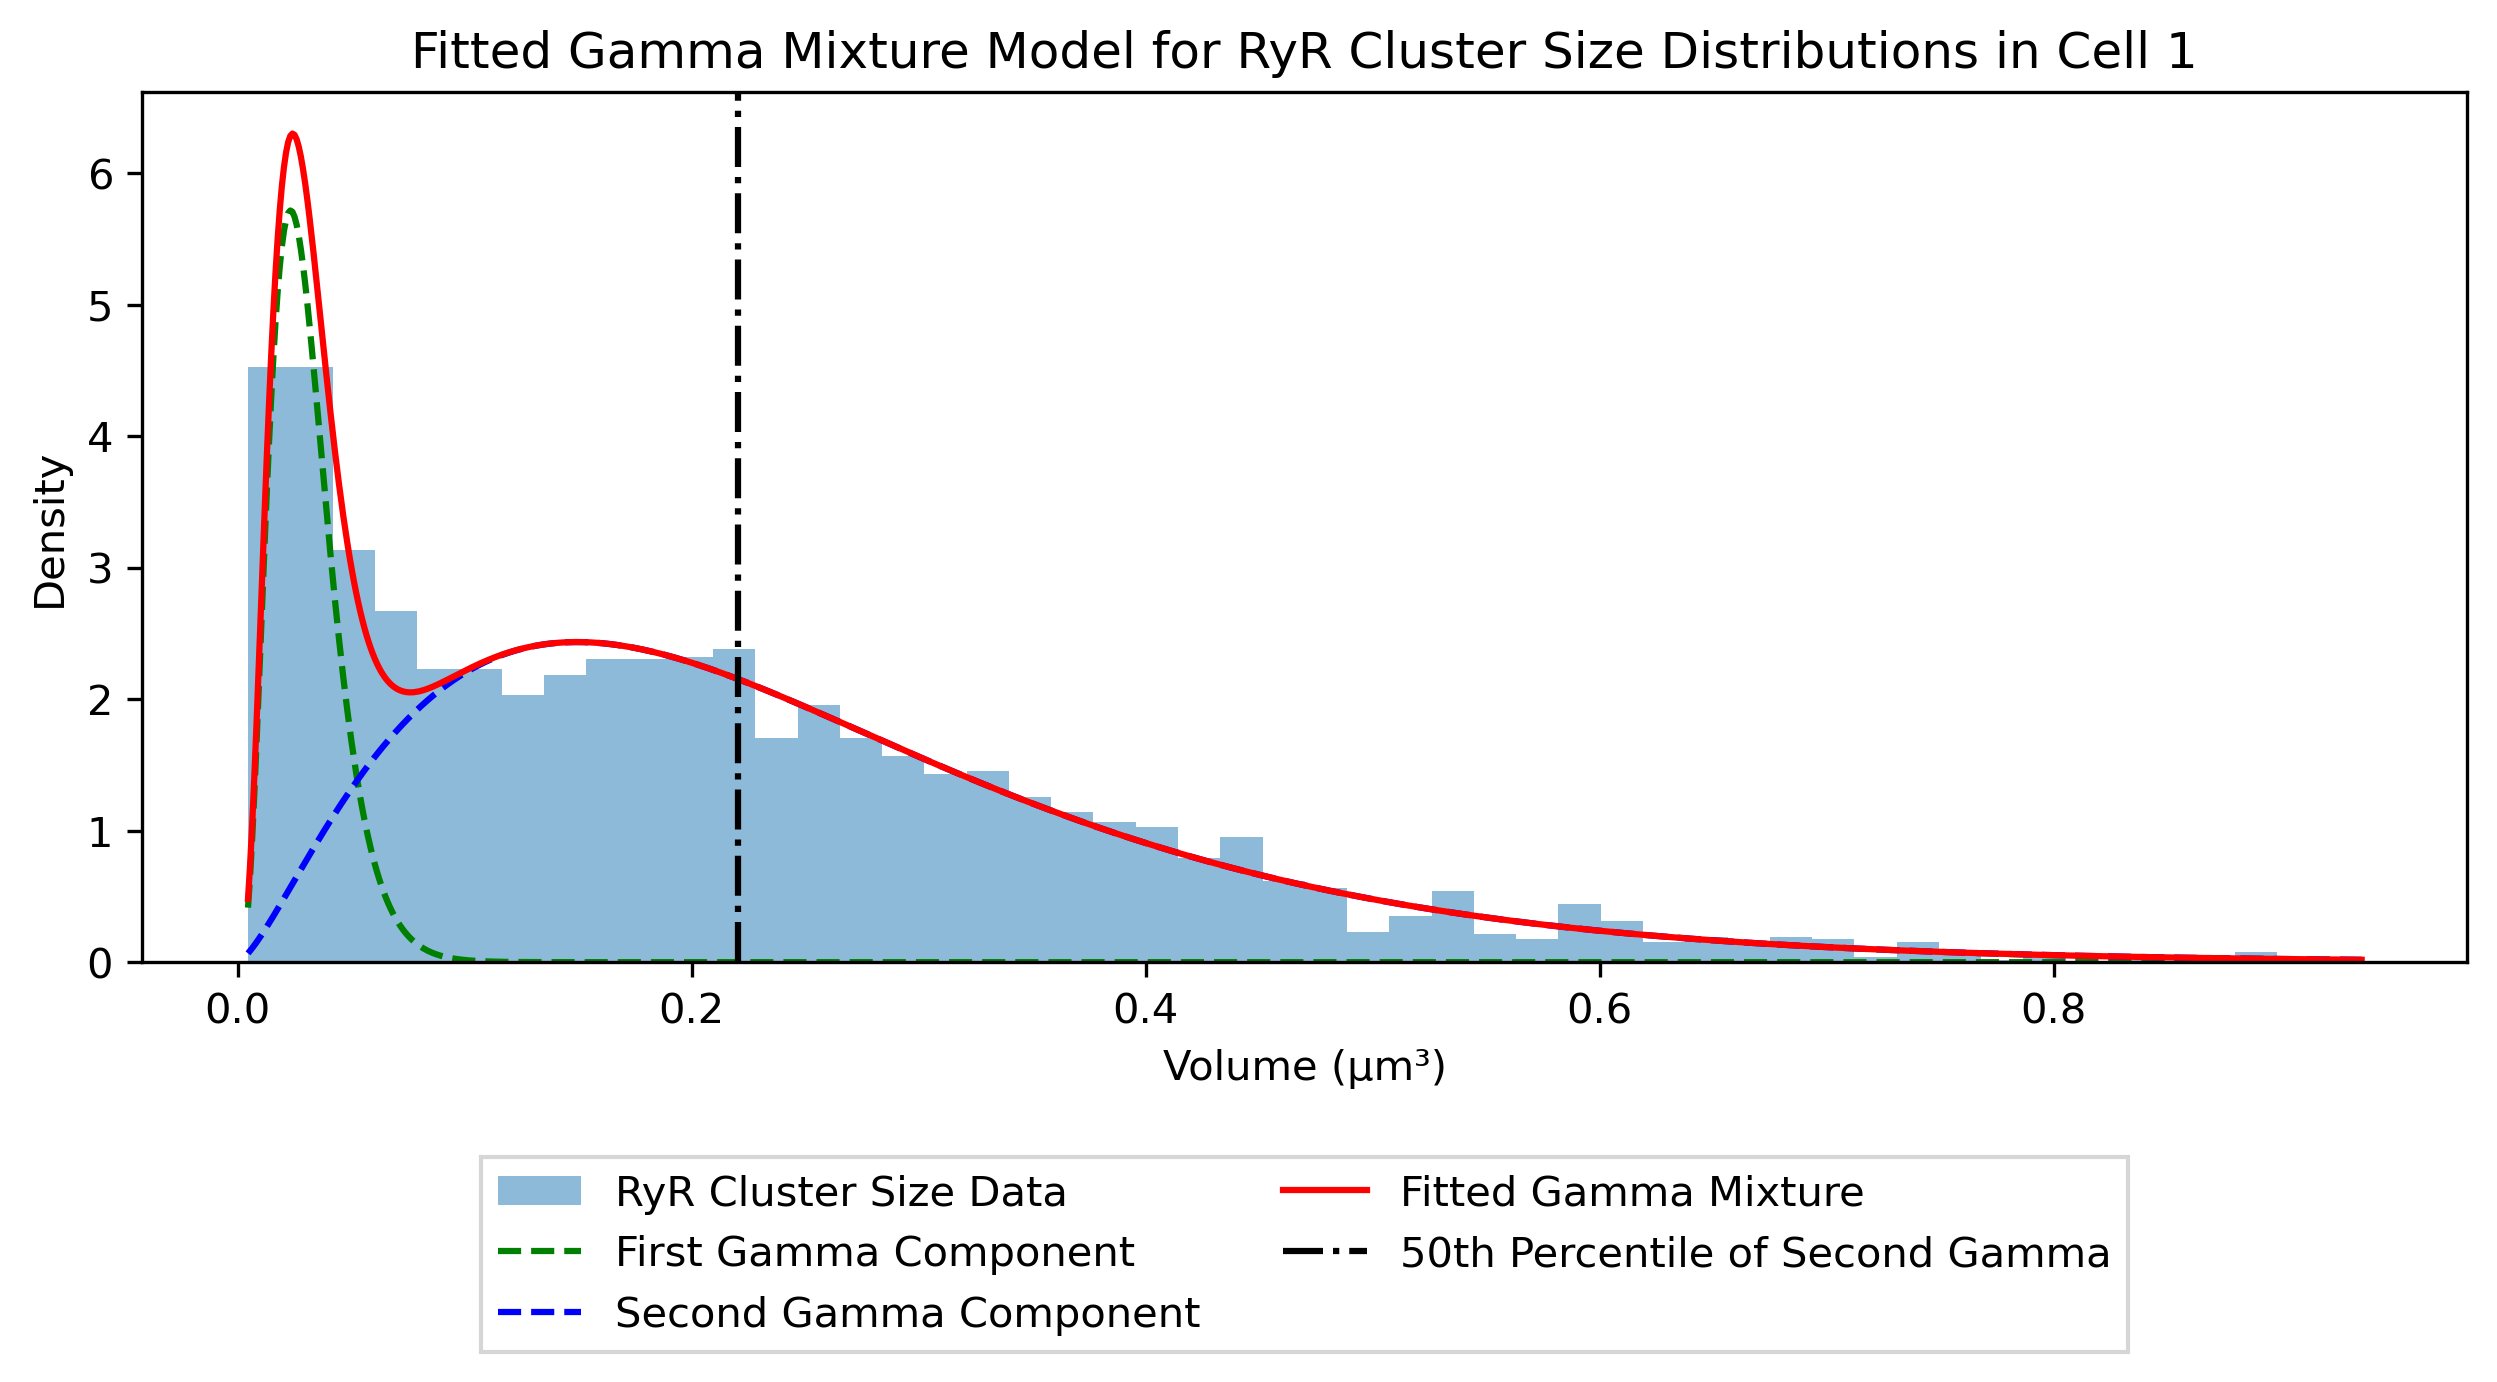

In [22]:
# List all the cell identifiers
print("Available cells:")
cell_identifiers = list(per_cell_data.keys())
for idx, cell_identifier in enumerate(cell_identifiers):
    print(f"{idx+1}. {cell_identifier}")

# Prompt the user to select a cell
while True:
    try:
        cell_index = int(input("Enter the number corresponding to the cell you wish to visualize: ")) - 1
        if 0 <= cell_index < len(cell_identifiers):
            break
        else:
            print("Invalid number. Please enter a number from the list.")
    except ValueError:
        print("Invalid input. Please enter a valid number.")

# Get the selected cell identifier
selected_cell_identifier = cell_identifiers[cell_index]
print(f"\nYou have selected: {selected_cell_identifier}")

# Retrieve the data for the selected cell
cell_data = per_cell_data[selected_cell_identifier]
cell_volumes = cell_data['volumes']

# Retrieve the stored parameters for the selected cell
params_row = master_params_df[master_params_df['CellIdentifier'] == selected_cell_identifier]

if not params_row.empty:
    alpha1 = params_row['Alpha1'].values[0]
    theta1 = params_row['theta1'].values[0]
    alpha2 = params_row['Alpha2'].values[0]
    theta2 = params_row['theta2'].values[0]
    pi = params_row['Pi'].values[0]
    fit_params = [alpha1, theta1, alpha2, theta2, pi]
else:
    print(f"No stored parameters found for cell {selected_cell_identifier}")
    # Optionally, fit again
    fit_params, r_squared, threshold_percentile, fig = fit_gamma_mixture_model(
        cell_volumes, data_name=f'Cell {cell_index + 1}', nbins=50, verbose=True, plot=True, percentile_value=PERCENTILE_VALUE
    )
    plt.show()
    # Exit or continue
    exit()

# Get the cell number (index + 1)
cell_number = cell_index + 1

# Define the function to plot the GMM mixture with provided parameters
def plot_gamma_mixture_model_with_params(x_values, fit_params, cell_number, nbins=50, percentile_value=95):
    """
    Plot the gamma mixture model using provided parameters and output the parameter values.
    """
    # Extract parameters
    alpha1, theta1, alpha2, theta2, pi = fit_params
    
    # Output the parameters
    print(f"Parameters for Cell {cell_number}:")
    print(f"Alpha1 = {alpha1:.4f}")
    print(f"Alpha2 = {alpha2:.4f}")
    print(f"theta1 = {theta1:.4f}")
    print(f"theta2 = {theta2:.4f}")
    print(f"Pi = {pi:.4f}")
    
    # Convert data to numpy array
    x_array = np.array(x_values)
    
    # Define the gamma mixture PDF
    def gamma_mixture_pdf(x):
        gamma1_pdf = gamma.pdf(x, a=alpha1, scale=theta1)
        gamma2_pdf = gamma.pdf(x, a=alpha2, scale=theta2)
        return pi * gamma1_pdf + (1 - pi) * gamma2_pdf

    # Calculate the specified percentile of the second gamma distribution
    threshold_percentile = gamma.ppf(percentile_value / 100, a=alpha2, scale=theta2)
    print(f"\n{percentile_value}th percentile of the second gamma distribution: {threshold_percentile:.4f}")
    
    # Create figure and axis with higher DPI
    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
    ax.hist(x_array, bins=nbins, density=True, alpha=0.5, label='RyR Cluster Size Data')
    x_range = np.linspace(min(x_array), max(x_array), 1000)

    # Plot the individual gamma distributions
    gamma1_pdf = gamma.pdf(x_range, a=alpha1, scale=theta1)
    gamma2_pdf = gamma.pdf(x_range, a=alpha2, scale=theta2)
    ax.plot(x_range, pi * gamma1_pdf, 'g--', label='First Gamma Component')
    ax.plot(x_range, (1 - pi) * gamma2_pdf, 'b--', label='Second Gamma Component')

    # Plot the fitted mixture
    ax.plot(x_range, gamma_mixture_pdf(x_range), 'r-', label='Fitted Gamma Mixture')

    # Plot the percentile line
    ax.axvline(x=threshold_percentile, color='black', linestyle='dashdot',
                label=f'{percentile_value}th Percentile of Second Gamma')

    ax.set_xlabel('Volume (μm³)')
    ax.set_ylabel('Density')
    ax.set_title(f'Fitted Gamma Mixture Model for RyR Cluster Size Distributions in Cell {cell_number}')

    # Adjust the layout to make room for the legend
    plt.subplots_adjust(bottom=0.3)

    # Place the legend below the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=False, shadow=False, ncol=2)

    # Show the plot
    plt.show()

# Call the function to plot the GMM mixture with stored parameters
plot_gamma_mixture_model_with_params(
    cell_volumes,
    fit_params,
    cell_number=cell_number,
    nbins=50,
    percentile_value=PERCENTILE_VALUE
)